In [1]:
import dask
from dask.distributed import Client
import dask.dataframe as dd
import pandas as pd
import os
import numpy as np
import json
from tqdm import tqdm
from scipy import sparse

In [2]:
import matplotlib.pyplot as plt 
from glob import glob

# Benign vs. Malware EDA

In [3]:
benignfp = "../data/datasets/interim/b_features/*csv"
malwarefp = "../data/datasets/interim/m_features/*csv"

How many benign apk I have ingested, processed

In [4]:
len(glob(benignfp))

2747

How many malware apk I have ingested, processed

In [5]:
len(glob(malwarefp))

2030

Before we do our EDA, lets see the size of each csv features, (in MB)

In [6]:
benign_apps = [i.split('/')[-1] for i in glob(benignfp)]
benign_size = [os.path.getsize(i)/(1024*1024) for i in glob(benignfp)]
benign_size = pd.Series(index = benign_apps, data = benign_size)
malware_apps = [i.split('/')[-1] for i in glob(malwarefp)]
malware_size = [os.path.getsize(i)/(1024*1024) for i in glob(malwarefp)]
malware_size = pd.Series(index = malware_apps, data = malware_size)

In [7]:
benign_size.shape

(2747,)

In [8]:
malware_size.shape

(2030,)

The Stats of benign feature file of benign and malware

In [9]:
benign_size.describe()

count    2747.000000
mean       13.032417
std        12.185762
min         0.000685
25%         5.733237
50%        11.156393
75%        17.386611
max       342.888342
dtype: float64

In [10]:
malware_size.describe()

count    2030.000000
mean        1.359864
std         2.170633
min         0.011738
25%         0.085016
50%         0.285466
75%         1.888253
max        25.360481
dtype: float64

- We notice that most of the malware apps are less than 2 MB, and the most of benign apps are less than 20 MB, which makes significantly different in app size and computation complexity. So we want to design a ML model down cast to small apps
- Specifically, we will add a constraint to app size, 3 MB

In [11]:
benign_size = benign_size[benign_size <= 3]

In [12]:
malware_size = malware_size[malware_size <= 3]

- The Stats of downcasted apps

In [13]:
benign_size.describe()

count    405.000000
mean       1.060372
std        0.849133
min        0.000685
25%        0.312517
50%        0.838329
75%        1.733680
max        2.976587
dtype: float64

In [14]:
malware_size.describe()

count    1721.000000
mean        0.622749
std         0.827421
min         0.011738
25%         0.082823
50%         0.160114
75%         0.874394
max         2.993118
dtype: float64

we will make the classification balanced, so we sample the same amount malwares

In [15]:
malware_size = malware_size.sample(n = len(benign_size), random_state = 1)

In [16]:
malware_size.describe()

count    405.000000
mean       0.531803
std        0.758693
min        0.016807
25%        0.076918
50%        0.110209
75%        0.690264
max        2.993118
dtype: float64

In [17]:
malware_size

18bcefdd591205ddedf3382f5fd22a05.csv    1.404254
457421a21f539881d78497b9e8b53584.csv    0.057405
fb740d902a18519d46e15dedf6d135a1.csv    0.085115
2a96efaab45addbeab73abb96ee91034.csv    0.019603
0b6c95bfce7086d6e707c481d4de99f2.csv    0.204378
                                          ...   
1c54e569ea432df901853f34723485bc.csv    0.097392
0811a208c0c87aa8e3af6b714921f155.csv    0.080320
cacfee038d26131a8568b3c11ee7f840.csv    0.541179
b83df8e33875745aaf2459dcc9f302b2.csv    0.080189
40285e00b0e9204bd25cb7dd34d1c2c9.csv    0.060081
Length: 405, dtype: float64

In [18]:
benign_dir = pd.Series(benign_size.index.tolist())\
            .apply(lambda x: os.path.join('../data/datasets/interim/b_features', x)).tolist()
malware_dir = pd.Series(malware_size.index.tolist())\
            .apply(lambda x: os.path.join('../data/datasets/interim/m_features', x)).tolist()

In [19]:
client = Client(n_workers = 8)

In [20]:
client

Client Scheduler: tcp://127.0.0.1:34579 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 68.72 GB


In [21]:
benign = dd.concat([dd.read_csv(i) for i in benign_dir])
malware = dd.concat([dd.read_csv(i) for i in malware_dir])

In [22]:
display(benign.head())
display(malware.head())

,api,invocation,block,app,malware
0,Ljava/lang/Object;-><init>,invoke-direct,constructor <init>(Lair/com/galactig/revision2...,adolygu-revision,0
1,Lair/com/galactig/revision2017/AppEntry;->acce...,invoke-static,public onClick(Landroid/content/DialogInterfac...,adolygu-revision,0
2,Lair/com/galactig/revision2017/AppEntry;->acce...,invoke-static,public onClick(Landroid/content/DialogInterfac...,adolygu-revision,0
3,Lair/com/galactig/revision2017/AppEntry;->acce...,invoke-static,public onClick(Landroid/content/DialogInterfac...,adolygu-revision,0
4,Lcom/adobe/air/InstallOfferPingUtils;->PingAnd...,invoke-static,public onClick(Landroid/content/DialogInterfac...,adolygu-revision,0


,api,invocation,block,app,malware
0,Ljava/lang/Object;-><init>,invoke-direct,constructor <init>(Lcom/radioadv/AddEditContac...,18bcefdd591205ddedf3382f5fd22a05,1
1,Lcom/radioadv/AddEditContacts;->access$0,invoke-static,public onClick(Landroid/view/View;)VAddEditCon...,18bcefdd591205ddedf3382f5fd22a05,1
2,Lcom/radioadv/AddEditContacts;->access$1,invoke-static,public onClick(Landroid/view/View;)VAddEditCon...,18bcefdd591205ddedf3382f5fd22a05,1
3,Ljava/lang/Object;-><init>,invoke-direct,constructor <init>(Lcom/radioadv/AddEditContac...,18bcefdd591205ddedf3382f5fd22a05,1
4,Lcom/radioadv/AddEditContacts;->access$0,invoke-static,public onClick(Landroid/view/View;)VAddEditCon...,18bcefdd591205ddedf3382f5fd22a05,1


## API Calls

### how many rows benign apps have

In [23]:
len(benign)

2748728

### how many rows malware apps have

In [24]:
len(malware)

1377097

### how many benign sample we collected

In [25]:
len(benign.app.unique())

405

### how many malware samples we collected

In [26]:
len(malware.app.unique())

405

### TOP 20 normalized API call comparison 

In [27]:
apical_v = benign.api.value_counts().compute()
apical_v_m = malware.api.value_counts().compute()

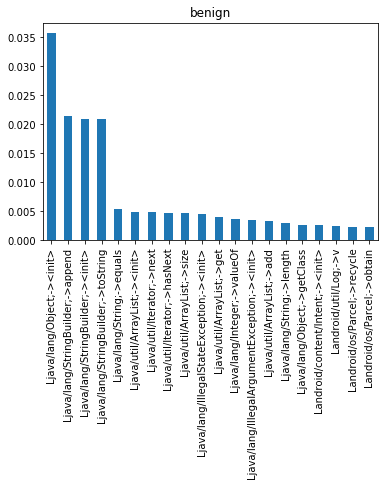

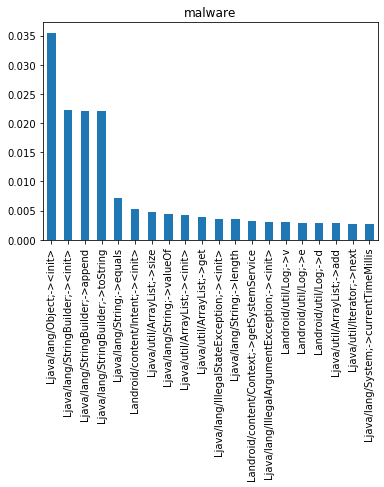

In [28]:
plt.show((apical_v / apical_v.sum()).head(20).plot.bar(title = "benign"))
plt.show((apical_v_m / apical_v_m.sum()).head(20).plot.bar(title = "malware"))

### TOP 100 api calls (percentage in common)

In [29]:
apical_v.head(100).isin(apical_v_m.head(100)).mean()

0.01

### Observation
Following finding from eda above:
  - In general, Benign apps are much more complicated than malware apps in structures. we collected 89 benign apps and 63 malware apps, but there are 6190118 rows of infomation for benign apps and 39345 rows of information for malware apps.
  - As plot shown above, the proportion (distribution) of Malware and Benign's api calls are relatively same.
  - The most common api calls are significantly different. For top 100 api calls of benign apps and malware apps, there are nearly no common api calls.

## Number of abnormal Apis

to find the cut between normal api and abnormal api

In [33]:
bgrouped = benign.groupby('api').size().compute()
mgrouped = malware.groupby('api').size().compute()

Stats of benign distinct api counts

In [34]:
bgrouped.describe()

count    216500.000000
mean         12.696194
std         326.005224
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max       98202.000000
dtype: float64

Stats of malware distinct api counts

In [35]:
mgrouped.describe()

count    93928.000000
mean        14.645984
std        254.692561
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      48812.000000
dtype: float64

Number of abnormal api in benign apps

In [36]:
len(bgrouped[bgrouped <= 4])

167395

Number of abnormal api in malware apps

In [37]:
len(mgrouped[mgrouped <= 5])

70554

We noticed taht the there are much more abnormal APIS used in benign apps. We may filter out the abnormal api in model afterwards

## Block

In [38]:
bblock = benign.block.nunique().compute()
mblock = malware.block.nunique().compute()

How many blocks the benign apps have

In [39]:
bblock

259999

How many blocks the malware apps have

In [40]:
mblock

99840

In [41]:
bblock = benign.block.value_counts().compute()
mblock = malware.block.value_counts().compute()

Stats of how many api calls each block has for benign apps

In [42]:
bblock.describe()

count    259999.000000
mean         10.572071
std          48.680578
min           1.000000
25%           1.000000
50%           3.000000
75%           7.000000
max        4624.000000
Name: block, dtype: float64

In [43]:
mblock.describe()

count    99840.000000
mean        13.793039
std         42.077762
min          1.000000
25%          1.000000
50%          4.000000
75%         12.000000
max       1817.000000
Name: block, dtype: float64

## Package

In [31]:
bpackage = benign.api.str.split('->').compute()
mpackage = malware.api.str.split('->').compute()

In [36]:
bpackage = bpackage.apply(lambda x: x[0] if type(x) == list else x)

In [37]:
mpackage = mpackage.apply(lambda x: x[0] if type(x) == list else x)

stats of number of package used of benign apps

In [39]:
bpackage.value_counts().describe()

count     52161.000000
mean         52.696957
std        1137.859921
min           1.000000
25%           1.000000
50%           3.000000
75%          12.000000
max      175178.000000
Name: api, dtype: float64

stats of number of package used of malware apps

In [40]:
mpackage.value_counts().describe()

count    20552.000000
mean        66.935967
std        948.045867
min          1.000000
25%          1.000000
50%          4.000000
75%         20.000000
max      92270.000000
Name: api, dtype: float64

The malwares are likely to use more same packages than benign apps did. So number of package used will be usefull.

## invocation

In [50]:
binvo = benign.invocation.value_counts().compute()
minvo = malware.invocation.value_counts().compute()

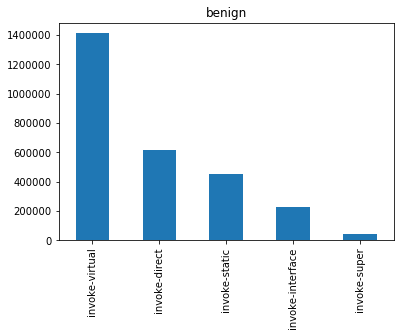

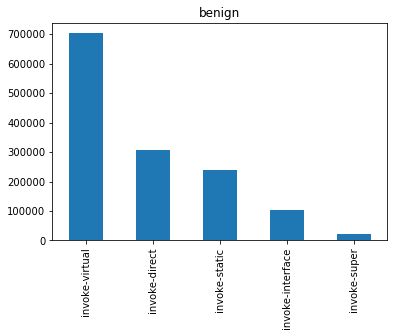

In [51]:
plt.show(binvo.plot.bar(title = 'benign'))
plt.show(minvo.plot.bar(title = 'benign'))

### Observation
Following finding from eda above:
  - In general, the distribution of invocation between benign apps and malware apps are roughly same: with invoke-virtual the most commonly used, and invok-super the least commonly used in both.
  - There is one abnormal scene found: in benign apps, invoke-static is the third commonly used, and invoke-interface is the fourth commonly used. But in malware apps, invoke-interface is the third commonly used, and invoke-static is the fourth commonly used. To ensure the abnormality, we should fetch more data.

In [42]:
import json
output_json = {'benign': benign_dir, 'malware': malware_dir}
with open('../config/train-params.json', 'w') as f:
    json.dump(output_json, f)

In [43]:
json.load(open('../config/train-params.json'))

{'benign': ['../data/datasets/interim/b_features/adolygu-revision.csv',
  '../data/datasets/interim/b_features/fruity-assassin.csv',
  '../data/datasets/interim/b_features/franck-dubosc-fan.csv',
  '../data/datasets/interim/b_features/sms-loc-lokalisierung-per-sms.csv',
  '../data/datasets/interim/b_features/kumpulan-aneka-resep-kue-basah.csv',
  '../data/datasets/interim/b_features/dua-e-sabaasab.csv',
  '../data/datasets/interim/b_features/vumeter-audiospectrumanalyzer.csv',
  '../data/datasets/interim/b_features/pmg.csv',
  '../data/datasets/interim/b_features/black-hat-prince-early-preview-unreleased.csv',
  '../data/datasets/interim/b_features/%E3%83%91%E3%83%BC%E3%82%AD%E3%83%B3%E3%82%B0%E3%83%A1%E3%83%A2.csv',
  '../data/datasets/interim/b_features/metal-style.csv',
  '../data/datasets/interim/b_features/exasale.csv',
  '../data/datasets/interim/b_features/black-see-through-girl-dodol.csv',
  '../data/datasets/interim/b_features/letter-words-to-morse-code-v-1.csv',
  '../data/da